# Reproduce the Laplace-approximated NAM
## References
```  
@misc{bouchiat2023laplaceapproximated,
      title={Laplace-Approximated Neural Additive Models: Improving Interpretability with Bayesian Inference}, 
      author={Kouroche Bouchiat and Alexander Immer and Hugo Yèche and Gunnar Rätsch and Vincent Fortuin},
      year={2023},
      eprint={2305.16905},
      archivePrefix={arXiv},
      primaryClass={stat.ML}
}
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import parameters_to_vector, vector_to_parameters

from LANAM.models import LaNAM, BayesianLinearRegression

from LANAM.config.default import defaults

from LANAM.trainer.training import *
from LANAM.trainer.marglik_training import *

from LANAM.data.generator import *
from LANAM.data.toydataset import ToyDataset

from LANAM.utils.plotting import * 

import matplotlib.pyplot as plt 
import numpy as np


from laplace import Laplace
from laplace import marglik_training as lamt
from laplace.curvature.backpack import BackPackGGN
"""
Reference:
@misc{kayid2020nams,
  title={Neural additive models Library},
  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},
  year={2020}
}
"""

'\nReference:\n@misc{kayid2020nams,\n  title={Neural additive models Library},\n  author={Kayid, Amr and Frosst, Nicholas and Hinton, Geoffrey E},\n  year={2020}\n}\n'

In [2]:
%reload_ext autoreload 
%autoreload 2

## test: linear toy data
1. dataset: $y \sim N(f(x), \sigma^2)$, where $f(x) = 0.3x-0.7, \sigma = 0.2$.
2. model: Bayesian linear regression, Linear layer with laplace approximation, LA-NAM

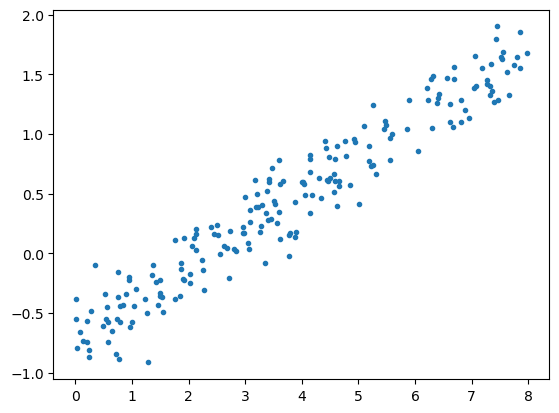

In [3]:
slope, bias = 0.3, -0.7
X_train, y_train, train_loader, X_test = get_linear_examples(slope=slope, bias=bias)
X_val, y_val, val_loader, _ = get_linear_examples(slope=slope, bias=bias)

plt.plot(X_train, y_train, '.')

In [4]:
def get_blr(X, y): 
    return BayesianLinearRegression(X, y)

def get_lanam(in_features, cfg):
    return LaNAM(
            config=cfg, 
            name="LaNAM", 
            in_features=in_features, 
            hessian_structure='full')

def get_linear_model(): 
    return nn.Linear(1, 1)

In [5]:
cfg = defaults()
cfg.hidden_sizes = []
cfg.activation = False
in_features = X_train.shape[1]

In [6]:
blr = get_blr(X_train, y_train)
lanam = get_lanam(in_features, cfg)
print(lanam)
loss = train(cfg, lanam, train_loader, val_loader)
lanam.fit(loss, train_loader)

LaNAM(
  (lossfunc): MSELoss()
  (_feature_nns): ModuleList(
    (0): FeatureNN(
      (model): Sequential(
        (0): Linear(in_features=1, out_features=1, bias=True)
      )
    )
  )
)
=============EPOCH 1==============
loss_train:  9.843, loss_val:  9.638
=============EPOCH 101==============
loss_train:  0.038, loss_val:  0.040
=============EPOCH 201==============
loss_train:  0.035, loss_val:  0.039
=============EPOCH 301==============
loss_train:  0.035, loss_val:  0.039
Finished Training.


In [7]:
linear_model = get_linear_model()
params = parameters_to_vector(lanam.feature_nns[0].parameters()).detach()
print(params)
vector_to_parameters(params, linear_model.parameters()) # assign nam and linear layer the same parameters
# loss = train(cfg, linear_model, train_loader, val_loader)
la = Laplace(linear_model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)

tensor([ 0.3024, -0.7026])


In [8]:
np.testing.assert_allclose(la.posterior_precision, lanam.posterior_precision, atol=1e-6)
np.testing.assert_allclose(blr.posterior_precision, lanam.posterior_precision, atol=1e-3)

np.testing.assert_allclose(la.posterior_covariance, lanam.posterior_covariance, atol=1e-6)

f_mu_blr, f_var_blr = blr.predict(X_test)
f_mu_la, f_var_la = la(X_test)
f_mu_lanam, f_var_lanam, fnn_mu, fnn_var = lanam.predict(X_test)

#np.testing.assert_allclose(f_var_blr.flatten(), f_var_la.flatten(), atol=1e-6)
np.testing.assert_allclose(f_var_lanam.flatten(), f_var_la.flatten(), atol=1e-8)

np.testing.assert_allclose(f_mu_blr.flatten(), f_mu_lanam.flatten(), atol=1e-1)
np.testing.assert_allclose(f_mu_la.flatten(), f_mu_lanam.flatten(), atol=1e-8)

In [9]:
print(lanam.sigma_noise)
print(lanam.feature_nns[0].sigma_noise)
print(lanam.feature_nns[0].la.sigma_noise)

tensor([1.])
tensor(1.)
tensor(1.)


### post-hoc tuning

In [10]:
# la-nam
n_epochs = 1000
log_prior, log_sigma = torch.ones(in_features, requires_grad=True), torch.ones(in_features, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - lanam.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [11]:
# laplace-torch
log_prior_, log_sigma_ = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior_, log_sigma_], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior_.exp(), log_sigma_.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [12]:
# Bayesian linear regression
log_sigma = torch.ones(1, requires_grad=True) # log std deviation of the regression Gaussian noise
log_prior_var = torch.ones(1, requires_grad=True) # log variance of parameter prior 
lr = 1e-1
optimizer = torch.optim.Adam([log_prior_var, log_sigma], lr=lr)
for epoch in range(n_epochs): 
    optimizer.zero_grad()
    neg_log_marg_lik = -blr.log_marginal_likelihood(log_prior_var.exp(), log_sigma.exp())
    neg_log_marg_lik.backward()
    optimizer.step()

In [13]:
from math import sqrt, pi
print(lanam.sigma_noise, la.sigma_noise)
print(lanam.prior_precision, la.prior_precision)

print(lanam._H_factor, la._H_factor)
print(lanam.n_data, la.n_data)
print(lanam.n_outputs, la.n_outputs)
print(lanam.loss, la.loss)

print(lanam.posterior_covariance, la.posterior_covariance)
print(lanam.log_likelihood, la.log_likelihood)
print(lanam.log_marginal_likelihood(), la.log_marginal_likelihood())

tensor([0.1890], grad_fn=<MulBackward0>) tensor(0.1889, grad_fn=<SelectBackward0>)
tensor([3.4143], grad_fn=<MulBackward0>) tensor([3.4143], grad_fn=<ExpBackward0>)
tensor(28.0067, grad_fn=<DivBackward0>) tensor(28.0311, grad_fn=<DivBackward0>)
200 200
1 1
tensor(3.5349) tensor(3.5318)
tensor([[ 3.4914e-05, -1.3075e-04],
        [-1.3075e-04,  6.6804e-04]], grad_fn=<MmBackward0>) tensor([[ 3.4884e-05, -1.3063e-04],
        [-1.3063e-04,  6.6746e-04]], grad_fn=<MmBackward0>)
tensor(50.4556, grad_fn=<SubBackward0>) tensor(50.5425, grad_fn=<SubBackward0>)
tensor(41.2377, grad_fn=<SubBackward0>) tensor(41.3238, grad_fn=<SubBackward0>)


In [15]:
sigma_lanam = lanam.sigma_noise.detach() 
sigma_la = la.sigma_noise.detach()
prior_lanam = lanam.prior_precision.detach()
prior_la = la.prior_precision.detach()

sigma_blr = blr.sigma_noise.detach()
prior_blr = blr.prior_precision.detach()

print(sigma_la, sigma_lanam, sigma_blr)
print(prior_la, prior_lanam, prior_blr)
np.testing.assert_allclose(sigma_la, sigma_lanam, atol=1e-2)
np.testing.assert_allclose(prior_la, prior_lanam, atol=1e-1)

tensor(0.1889) tensor([0.1890]) tensor([0.1889])
tensor([3.4143]) tensor([3.4143]) tensor([3.4286])


### online tuning

In [16]:
linear_model = get_linear_model()
n_epochs = 300
la, linear_model, margliks, losses = lamt(
    model=linear_model, train_loader=train_loader, likelihood='regression',
    hessian_structure='full', backend=BackPackGGN, n_epochs=n_epochs, 
    optimizer_kwargs={'lr': 1e-2}, prior_structure='scalar'
)

In [21]:
lanam = get_lanam(in_features, cfg)
lanam, margliks, losses = marglik_training(
    lanam, train_loader, train_loader, 'regression', n_epochs=n_epochs, hessian_structure='full', backend=BackPackGGN,
    optimizer_kwargs={'lr': 1e-2})

EPOCH=1: epoch_loss= 1.727, epoch_perf= 1.722
EPOCH=51: epoch_loss= 0.038, epoch_perf= 0.038
EPOCH=101: epoch_loss= 0.036, epoch_perf= 0.036
EPOCH=151: epoch_loss= 0.036, epoch_perf= 0.036
EPOCH=201: epoch_loss= 0.036, epoch_perf= 0.036
EPOCH=251: epoch_loss= 0.036, epoch_perf= 0.036
MARGLIK: finished training. Recover best model and fit Laplace.


In [22]:
params = parameters_to_vector(lanam.feature_nns[0].parameters()).detach()
print(params, blr.mean.flatten(), la.mean)

tensor([ 0.2966, -0.6997]) tensor([ 0.3019, -0.7010], grad_fn=<ReshapeAliasBackward0>) tensor([ 0.2953, -0.6930])


In [23]:
from math import sqrt, pi
print(lanam.sigma_noise, la.sigma_noise)
print(lanam.prior_precision, la.prior_precision)

print(lanam._H_factor, la._H_factor)
print(lanam.n_data, la.n_data)
print(lanam.n_outputs, la.n_outputs)
print(lanam.loss, la.loss)

print(lanam.posterior_covariance, la.posterior_covariance)
print(lanam.log_likelihood, la.log_likelihood)
print(lanam.log_marginal_likelihood(), la.log_marginal_likelihood())

tensor([0.1906], grad_fn=<MulBackward0>) tensor(0.1903)
tensor([3.5204], grad_fn=<MulBackward0>) tensor([3.5200])
tensor(27.5164, grad_fn=<DivBackward0>) tensor(27.6278)
200 200
1 1
tensor(3.5978) tensor(3.5834)
tensor([[ 3.5533e-05, -1.3306e-04],
        [-1.3306e-04,  6.7987e-04]], grad_fn=<MmBackward0>) tensor([[ 3.5390e-05, -1.3253e-04],
        [-1.3253e-04,  6.7713e-04]])
tensor(48.6920, grad_fn=<SubBackward0>) tensor(49.0934)
tensor(39.5225, grad_fn=<SubBackward0>) tensor(39.9197)


In [25]:
sigma_lanam = lanam.sigma_noise.detach() 
sigma_la = la.sigma_noise.detach()
prior_lanam = lanam.prior_precision.detach()
prior_la = la.prior_precision.detach()
sigma_blr = blr.sigma_noise.detach()
prior_blr = blr.prior_precision.detach()
print(sigma_la, sigma_lanam, sigma_blr)
print(prior_la, prior_lanam, prior_blr)
np.testing.assert_allclose(sigma_la, sigma_lanam, atol=1e-3)
np.testing.assert_allclose(prior_la, prior_lanam, atol=1e-3)

tensor(0.1903) tensor([0.1906]) tensor([0.1889])
tensor([3.5200]) tensor([3.5204]) tensor([3.4286])


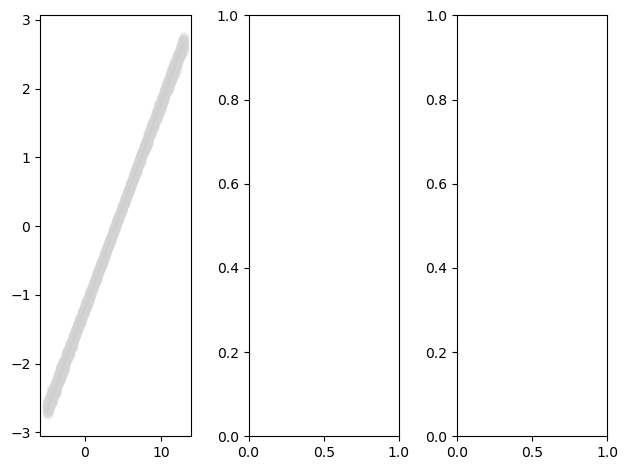

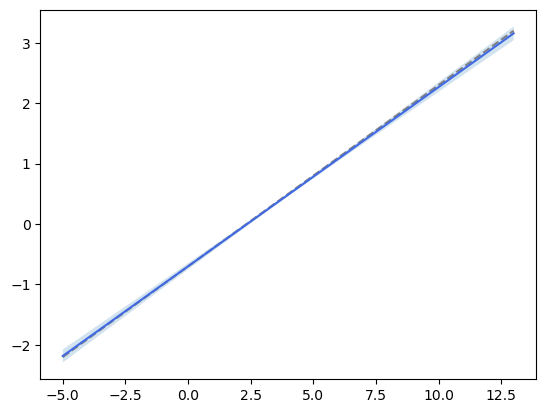

In [29]:
plot_predictive_posterior(lanam, testset)